# Problem Set 4a (20 pts)

This is based on the Neuromatch Academy tutorial: 

https://deeplearning.neuromatch.io/tutorials/W1D1_BasicsAndPytorch/student/W1D1_Tutorial1.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

### Starter Code: Create Data

/var/folders/kh/ghd6c8493xb47jcyghc180g80000gn/T/ipykernel_72693/3321901310.py:4: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = labels.astype(np.long)


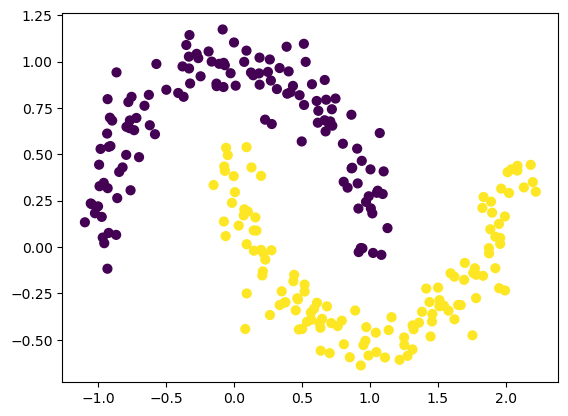

In [2]:
# Create a dataset of 256 points with a little noise
inputs, labels = make_moons(256, noise=0.1)
inputs = inputs.astype(np.float32)
labels = labels.astype(np.long)

# Visualize the dataset 
# Color of the points is determined by labels
plt.scatter(inputs[:, 0], inputs[:, 1], s=40, c=labels)
plt.show()

### Part 1: Implement a Multi-Layer Perceptron (MLP) class (2 pts)
Implement a class for constructing and running a MLP which inherits from the base class `nn.Module`. Please implement the `__init__`, `forward`, and `predict` methods. The `__init__` method should construct the network architecture, `forward` should perform the forward pass of the network, and `predict` should run the forward pass **and** choose the most likely label. 


In [4]:
class MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, act=nn.ReLU): 
        super().__init__() 
        net = []
        prev_dim = in_size
        for hidden in hidden_size: 
            layer = nn.Linear(prev_dim, hidden) 
            net.append(layer)
            net.append(act())  
            prev_dim = hidden 

        layer = nn.Linear(prev_dim, out_size) 
        net.append(layer)
        self.net = nn.Sequential(*net) 
    
    def forward(self, x):
        return self.net(x)
    
    def predict(self, x):
        output = self.forward(x)
        return torch.argmax(output, dim = 1)

### Implement a Dataset class (2 pts)
Implement a dataset class which inherits from the `Dataset` base class. This module should implement the `__init__`, `__len__`, and `__getitem__` methods. The `__init__` method should store the inputs and outputs passed via arguments to the method, the `__len__` method should return the size of the dataset, and `__getitem__` should return the datapoint at the given index passed via an argument.

In [5]:
class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = torch.tensor(inputs)
        self.outputs = torch.tensor(outputs)

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

### Implement the Main Training Loop (8 pts)
Implement a function which iterates through a dataset and trains the model over a specified number of epochs. 

In addition to what we showed in class, create a Python list and append the current average loss at each epoch. You can compute the average loss over all the batches for a given epoch by keeping a running sum of the loss and dividing by the # of batches, which you can get with `len(dataloader)`. Be sure to zero the running sum after each epoch. Also, make sure to append only the value of the average loss to the list using `avg_loss.item()`, which returns the value of the scalar tensor as a standard Python number. 

We also want to keep track of the average magnitude of the gradients during training, which can be an important debugging tool. To get the average gradient magnitude of your network per batch, use the following function after calling the `backward()` method on your loss:

`np.mean([p.grad.norm() for p in model.parameters()])`

Just like with the loss, we want to keep a running average of this quantity each epoch as well and append it to its own separate list. Have the function return the loss and grad_norm lists after training. Additionally, display the epoch, average loss, and average grad_norm to the console every so often, where the amount is an argument to the function. This can be done with a simple `print` statement.

In [6]:
def Main_Training_Loop(data_loader, optimizer, loss_fn, model, num_epochs, amount):

    avg_losses = []
    avg_grad_mags = []

    for epoch in range(num_epochs):

        sum_losses = 0
        sum_grad_mags = 0

        for batch_idx, batch in enumerate(data_loader):
            input, target = batch
            optimizer.zero_grad()
            output = model(input)
            loss = loss_fn(output, target)

            sum_losses += loss

            loss.backward()

            # grad_mags = 
            sum_grad_mags += np.mean([p.grad.norm() for p in model.parameters()])
            
            optimizer.step()
        
        loss_fn.zero_grad()

        # avg_loss_over_batch = 
        avg_loss = (sum_losses / len(data_loader)).item()
        avg_losses.append(avg_loss)

        # avg_grad_over_batch = 
        avg_grad = (sum_grad_mags / len(data_loader)).item()
        avg_grad_mags.append(avg_grad)

        if epoch % amount == 0:
            print("Epoch: ", epoch)
            print("Average Loss: ", avg_loss)
            print("Average Gradient Norm: ", avg_grad)
            print('')
    
    return avg_losses, avg_grad_mags
        

### Construct the Model, Dataset, and Other Bits (2 pts)
First, let's create a specific MLP using our class. Then create an optimizer (SGD) and pass the parameters of the model as an argument. Additionally, instantiate a loss function for our classification task (cross entropy loss). Finally, create a dataset using our dataset class and the Moons data we provided in the starter code. Wrap this dataset in a `DataLoader`, which will handle batching of the data for us. Please create an MLP which takes in 2 inputs (the x and y coordinates), has a single hidden layer of 16 neurons, has 2 outputs (the two possible classes), and uses ReLU activation functions. Use a learning rate of 1e-2 and a batch size of 32.

In [7]:
model = MLP(2, 2, [16])

optimizer_init = optim.SGD(model.parameters(), lr = 1e-2)
loss_fn = nn.CrossEntropyLoss()
print(loss_fn)

dataset = MyDataset(inputs, labels)
loader = DataLoader(dataset, batch_size = 32, num_workers = 0)

CrossEntropyLoss()


### Train the Model (0 pts)
Train your model using your training loop for 15000 epochs. 

In [24]:
avg_losses, avg_grad_mags = Main_Training_Loop(data_loader= loader, optimizer= optimizer_init, loss_fn= loss_fn, model= model, num_epochs= 15000, amount= 1000)

Epoch:  0
Average Loss:  0.6502352952957153
Average Gradient Norm:  0.1482527069747448
Epoch:  1000
Average Loss:  0.1203603446483612
Average Gradient Norm:  0.07582867960445583
Epoch:  2000
Average Loss:  0.042219385504722595
Average Gradient Norm:  0.04932511504739523
Epoch:  3000
Average Loss:  0.022686265408992767
Average Gradient Norm:  0.03480402869172394
Epoch:  4000
Average Loss:  0.015077963471412659
Average Gradient Norm:  0.027314418111927807
Epoch:  5000
Average Loss:  0.01110050454735756
Average Gradient Norm:  0.02247834438458085
Epoch:  6000
Average Loss:  0.008681397885084152
Average Gradient Norm:  0.01909710478503257
Epoch:  7000
Average Loss:  0.007015869952738285
Average Gradient Norm:  0.016376120038330555
Epoch:  8000
Average Loss:  0.005870481487363577
Average Gradient Norm:  0.014737178455106914
Epoch:  9000
Average Loss:  0.005024271085858345
Average Gradient Norm:  0.01314472485682927
Epoch:  10000
Average Loss:  0.004375928081572056
Average Gradient Norm:  0.

### Generate Average Loss Plot (4 pts)
Plot the average loss and gradient norms during training. Create two subplots with "Epoch" on the x-axis and  "Average Loss" and "Average Gradient Norm" on the y-axes, respectively. 

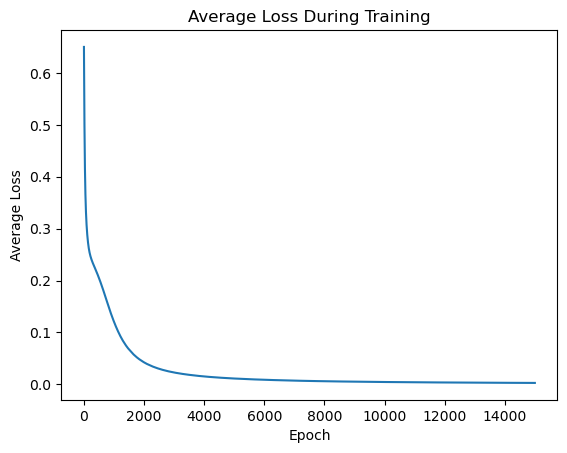

In [26]:
Epoch = np.arange(0, len(avg_losses), 1)

plt.plot(Epoch, avg_losses);
plt.xlabel("Epoch");
plt.ylabel("Average Loss");
plt.title("Average Loss During Training");

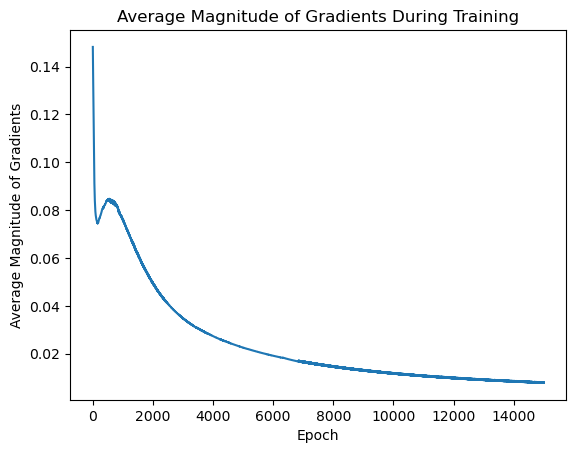

In [27]:
Epoch = np.arange(0, len(avg_losses), 1)

plt.plot(Epoch, avg_grad_mags);
plt.xlabel("Epoch");
plt.ylabel("Average Magnitude of Gradients");
plt.title("Average Magnitude of Gradients During Training");

### Starter Code: Helper Function to Plot the Decision Boundary

In [16]:
def plot_decision_boundary(learning_rate, model, inputs, labels):
    # Set min and max values and give it some padding
    x_min, x_max = inputs[:, 0].min() - .5, inputs[:, 0].max() + .5
    y_min, y_max = inputs[:, 1].min() - .5, inputs[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
    grid_points = torch.tensor(grid_points).float()
    outputs = model.predict(grid_points).numpy()
    outputs = outputs.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, outputs, cmap=plt.cm.Spectral)
    plt.scatter(inputs[:, 0], inputs[:, 1], c=labels, cmap=plt.cm.binary)
    plt.title('Learning Rate = ' + str(learning_rate))

### Generate Decision Boundary Plot (2 pts)
Use the starter code above to plot the decision boundary of your network along with the data points.

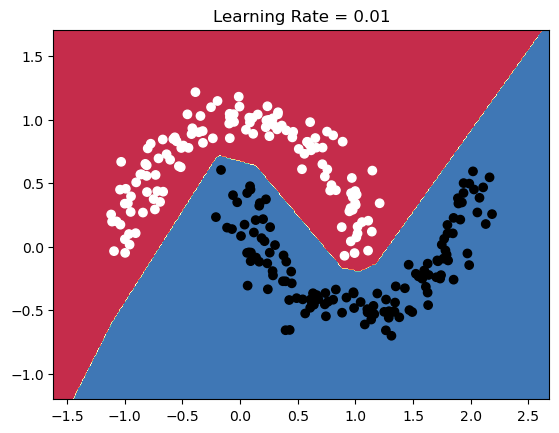

In [51]:
plot_decision_boundary(learning_rate = 1e-2, model = model, inputs = inputs, labels = labels)

### Hyperparameter Exploration
Now we're going to perform some hyperparameter exploration. First, increase the learning rate by powers of 10 until the optimization either diverges or fails to converge. Then decrease the learning rate by powers of 10 until we fail to converge within the 15000 epochs (the decision boundary should be wrong). Please re-train the network for these different settings, re-generate the plots, and save them to file. You will then need to create a write-up which includes these plots and comment on the trends you see when tweaking the learning rate. We recommend that you use LaTeX, but you can use any tool you wish as long as you export it as a PDF.

Epoch:  0
Average Loss:  0.0011137679684907198
Average Gradient Norm:  0.004027188188047148

Epoch:  1000
Average Loss:  0.0007846528897061944
Average Gradient Norm:  0.0029344193171709776

Epoch:  2000
Average Loss:  0.0005999463610351086
Average Gradient Norm:  0.0023815065578673966

Epoch:  3000
Average Loss:  0.0004828918317798525
Average Gradient Norm:  0.0019550460929167457

Epoch:  4000
Average Loss:  0.0004021097847726196
Average Gradient Norm:  0.0016993065255519468

Epoch:  5000
Average Loss:  0.0003432409721426666
Average Gradient Norm:  0.001430298796549323

Epoch:  6000
Average Loss:  0.0002988750347867608
Average Gradient Norm:  0.0013148892339813756

Epoch:  7000
Average Loss:  0.0002640972670633346
Average Gradient Norm:  0.0011708115016517695

Epoch:  8000
Average Loss:  0.00023622941807843745
Average Gradient Norm:  0.001037273787005688

Epoch:  9000
Average Loss:  0.00021334052144084126
Average Gradient Norm:  0.000939546052904916

Epoch:  10000
Average Loss:  0.0001

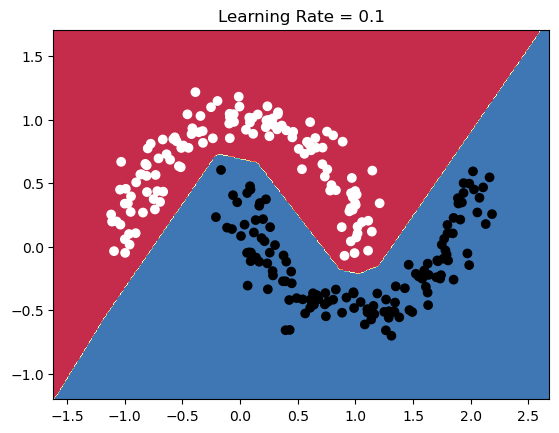

In [59]:
test_lr_1 = 1e-1
test_optimizer_1 = optim.SGD(model.parameters(), lr = test_lr_1)

test_avg_loss_1, test_avg_grad_mags_1 = Main_Training_Loop(data_loader= loader, optimizer= test_optimizer_1, loss_fn= loss_fn, model= model, num_epochs= 15000, amount= 1000)
plot_decision_boundary(learning_rate = test_lr_1, model = model, inputs = inputs, labels = labels)

Epoch:  0
Average Loss:  7.799138984410092e-05
Average Gradient Norm:  0.00039278278291021707

Epoch:  1000
Average Loss:  5.522218634723686e-05
Average Gradient Norm:  0.00028432304816305987

Epoch:  2000
Average Loss:  4.2431114707142115e-05
Average Gradient Norm:  0.0002262676334794378

Epoch:  3000
Average Loss:  3.425534669077024e-05
Average Gradient Norm:  0.00018602064790229633

Epoch:  4000
Average Loss:  2.8623773687286302e-05
Average Gradient Norm:  0.00015552247748473746

Epoch:  5000
Average Loss:  2.451992259011604e-05
Average Gradient Norm:  0.0001352405519128297

Epoch:  6000
Average Loss:  2.139981916116085e-05
Average Gradient Norm:  0.00011825553991684501

Epoch:  7000
Average Loss:  1.896171670523472e-05
Average Gradient Norm:  0.00010746396475269648

Epoch:  8000
Average Loss:  1.6990263247862458e-05
Average Gradient Norm:  9.731660469469716e-05

Epoch:  9000
Average Loss:  1.5374756912933663e-05
Average Gradient Norm:  8.725527402475564e-05

Epoch:  10000
Average L

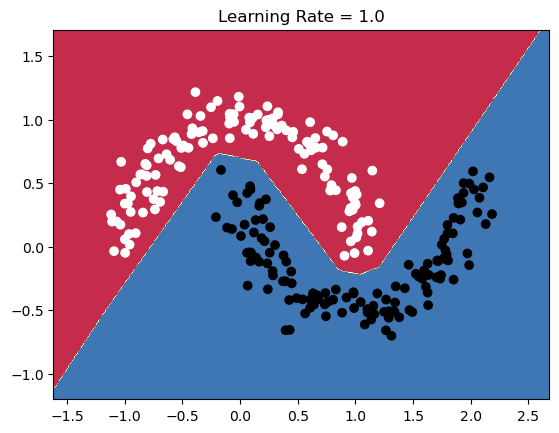

In [61]:
test_lr_2 = 1e0
test_optimizer_2 = optim.SGD(model.parameters(), lr = test_lr_2)

test_avg_loss_1, test_avg_grad_mags_1 = Main_Training_Loop(data_loader= loader, optimizer= test_optimizer_2, loss_fn= loss_fn, model= model, num_epochs= 15000, amount= 1000)
plot_decision_boundary(learning_rate = test_lr_2, model = model, inputs = inputs, labels = labels)

Epoch:  0
Average Loss:  413.09326171875
Average Gradient Norm:  0.17677669320255518

Epoch:  1000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  2000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  3000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  4000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  5000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  6000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  7000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  8000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  9000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epoch:  10000
Average Loss:  2.713811159133911
Average Gradient Norm:  0.15954547887668014

Epo

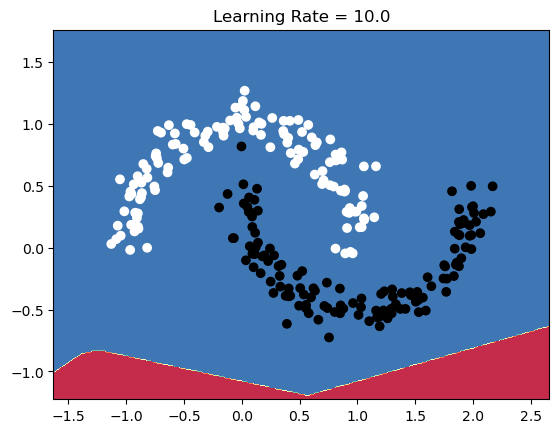

In [18]:
test_lr_1 = 1e1
test_optimizer_1 = optim.SGD(model.parameters(), lr = test_lr_1)

test_avg_loss_1, test_avg_grad_mags_1 = Main_Training_Loop(data_loader= loader, optimizer= test_optimizer_1, loss_fn= loss_fn, model= model, num_epochs= 15000, amount= 1000)
plot_decision_boundary(learning_rate = test_lr_1, model = model, inputs = inputs, labels = labels)

Epoch:  0
Average Loss:  1.3510080575942993
Average Gradient Norm:  0.15120691154152155

Epoch:  1000
Average Loss:  0.693631649017334
Average Gradient Norm:  0.04277624801034108

Epoch:  2000
Average Loss:  0.6931705474853516
Average Gradient Norm:  0.04146427066734759

Epoch:  3000
Average Loss:  0.6931703090667725
Average Gradient Norm:  0.04144654371668821

Epoch:  4000
Average Loss:  0.693170428276062
Average Gradient Norm:  0.041446538029333624

Epoch:  5000
Average Loss:  0.693170428276062
Average Gradient Norm:  0.041446538029333624

Epoch:  6000
Average Loss:  0.693170428276062
Average Gradient Norm:  0.041446538029333624

Epoch:  7000
Average Loss:  0.693170428276062
Average Gradient Norm:  0.041446538029333624

Epoch:  8000
Average Loss:  0.693170428276062
Average Gradient Norm:  0.041446538029333624

Epoch:  9000
Average Loss:  0.693170428276062
Average Gradient Norm:  0.041446538029333624

Epoch:  10000
Average Loss:  0.693170428276062
Average Gradient Norm:  0.04144653802

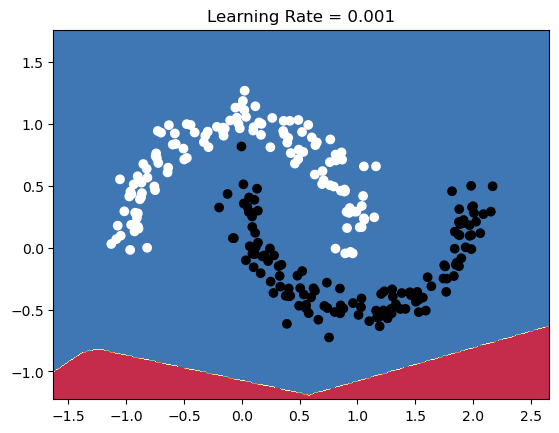

In [19]:
test_lr_1 = 1e-3
test_optimizer_1 = optim.SGD(model.parameters(), lr = test_lr_1)

test_avg_loss_1, test_avg_grad_mags_1 = Main_Training_Loop(data_loader= loader, optimizer= test_optimizer_1, loss_fn= loss_fn, model= model, num_epochs= 15000, amount= 1000)
plot_decision_boundary(learning_rate = test_lr_1, model = model, inputs = inputs, labels = labels)